In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kernel import Kernel

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"
plt.rc('text', usetex=True)

In [3]:
def generate_random_sphere(n_train, m):
    u = np.random.randn(n_train, m)
    u /= np.sqrt(np.sum(u**2, axis=1))[:, np.newaxis]
    return u

def get_stepsize(T, gamma_0=1):
    gamma = np.arange(T, dtype=float)
    gamma += 1
    np.sqrt(gamma, out=gamma)
    np.divide(1, gamma, out=gamma)
    gamma *= gamma_0
    return gamma

def median_error(y_pred, y_test, inplace=True):
    if inplace:
        err = y_pred
        err -= y_test
    else:
        err = y_pred - y_test
    err **= 2
    err = np.sum(err, axis=1)
    np.sqrt(err, out=err)
    np.abs(err, out=err)
    return err.mean()

def mean_error(y_pred, y_test, inplace=True):
    if inplace:
        err = y_pred
        err -= y_test
    else:
        err = y_pred - y_test
    err **= 2
    err *= err.shape[1]
    err = np.mean(err)
    return np.sqrt(err)

In [4]:
useful_col = [49, 50, 52, 54, 55, 56, 57]
df = pd.read_csv('bottle.csv', usecols=useful_col, dtype=float)
# print(df.count())
df.dropna(inplace=True)
df.set_index(np.arange(len(df)), inplace=True)

In [5]:
input_col = ['R_Depth', 'R_TEMP', 'R_SALINITY', 'R_SVA', 'R_DYNHT']
output_col = ['R_O2Sat']

n_train = 500000
n_repr = 1000
causal = False

if causal:
    # Training set
    x_train = df.iloc[:n_train][input_col].values
    y_train = df.iloc[:n_train][output_col].values

    # Testing set
    x_test = df.iloc[n_train:][input_col].values
    y_test = df.iloc[n_train:][output_col].values
else:
    # Training set
    index_train = np.random.choice(len(df), n_train, replace=False)
    x_train = df.iloc[index_train][input_col].values
    y_train = df.iloc[index_train][output_col].values

    # Testing set
    index_test = np.ones(len(df), dtype=np.bool_)
    index_test[index_train] = False
    x_test = df.iloc[index_test][input_col].values
    y_test = df.iloc[index_test][output_col].values

# Normalization
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)

x_train -= x_mean
x_train /= x_std
x_test -= x_mean
x_test /= x_std

# Small trainset and testset
n_small_train = 10000
ind = np.random.choice(len(x_train), n_small_train, replace=True)
x_small_train = x_train[ind]
y_small_train = y_train[ind]

n_small_test = 1000
ind = np.random.choice(len(x_test), n_small_test, replace=True)
x_small_test = x_test[ind]
y_small_test = y_test[ind]

# Normalized output (the easy part to learn)
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
y_train -= y_mean
y_train /= y_std
y_test -= y_mean
y_test /= y_std
y_small_test -= y_mean
y_small_test /= y_std

In [6]:
def easiest_baseline():
    print(median_error(np.zeros(y_test.shape), y_test))
    
easiest_baseline()

0.9028493314970552


In [7]:
# Linear regression baseline
def lin_reg_sol(x, y, lambd):
    n, d = x.shape
    A = x.T @ x
    A /= n
    A += lambd * np.eye(d)
    b = x.T @ y
    b /= n
    return np.linalg.solve(A, b)

def linreg_baseline():
    w = lin_reg_sol(x_train, y_train, 0)
    y_pred = x_test @ w
    linreg_baseline = median_error(y_pred, y_test)
    print(linreg_baseline)

linreg_baseline()

0.2151156822045958


In [21]:
def krr_sol(x, y, lambd, k):
    n = len(x)
    K = k(x)
    A = K @ K.T
    A /= n
    # A += lambd * np.eye(len(A))
    A += lambd * k.get_k()
    b = K @ y
    b /= n
    return np.linalg.solve(A, b)

def krr_Nystrom_baseline():
    # Kernel ridge regression baseline
    sigma = 1e0
    kernel = Kernel('gaussian', sigma=sigma)

    # Function parameterization
    n_repr = 100
    x_repr = x_train[:n_repr]
    kernel.set_support(x_repr)
    lambd = 1e-4
    # a = krr_sol(x_small_train, y_small_train, lambd, kernel)
    a = krr_sol(x_train[:n_repr], y_train[:n_repr], lambd, kernel)

    y_pred = kernel(x_small_test).T @ a
    # y_pred /= np.std(y_pred)
    krr_baseline = mean_error(y_pred, y_small_test)
    print(krr_baseline)

krr_Nystrom_baseline()

0.26580012434223593


In [9]:
def krr_baseline():
    # Kernel ridge regression baseline
    sigma = 1e0
    kernel = Kernel('gaussian', sigma=sigma)

    # Function parameterization
    n_repr = 5000
    x_repr = x_train[:n_repr]
    kernel.set_support(x_repr)
    K = kernel(x_repr)
    lambd = 1e-6 * n_repr
    K += lambd * np.eye(len(K))
    y_repr = y_train[:n_repr]
    alpha = np.linalg.solve(K, y_repr)

    y_pred = kernel(x_small_test).T @ alpha
    krr_baseline = mean_error(y_pred, y_small_test)
    print(krr_baseline)

krr_baseline()

0.15692324851450629


In [7]:
# Randomness control
np.random.seed(0)

# Random questions
n_train, m = y_train.shape
u = generate_random_sphere(n_train, m)

# Placeholders
theta_w = np.empty((n_repr, m))
theta_ave_w = np.empty((n_repr, m))
theta_f = np.empty((n_repr, m))
theta_ave_f = np.empty((n_repr, m))
grad = np.empty(theta_w.shape)

gammas = [1e-2]

# Placeholders
n_small_train = 10000
full_error_w = np.zeros((n_small_train, len(gammas)))
full_error_f = np.zeros((n_small_train, len(gammas)))
for i_g, gamma_0 in enumerate(gammas):
    gamma = get_stepsize(n_train, gamma_0)

    # Descent initialization
    random_init = False
    if random_init:
        theta_w[:] = .3 * np.random.randn(*grad.shape)
        theta_f[:] = .3 * np.random.randn(*grad.shape)
    else:
        theta_w[:] = 0
        theta_f[:] = 0
    theta_ave_f[:] = 0
    theta_ave_w[:] = 0

    for i in range(n_small_train):
        # New point
        K_train[:] = kernel(x_train[i:i+1]).T

        # Weakly supervised update
        epsilon = np.sign((K_train @ theta_w - y_train[i]) @ u[i])
        grad[:] = 1
        grad *= u[i]
        grad *= K_train.T
        grad *= epsilon * gamma[i]
        theta_w -= grad

        # Fully supervised update
        # grad[:] = 1
        # grad *= K_train @ theta_f - y_train[i]
        # grad /= np.sqrt(np.sum(grad[0]**2))
        # grad *= K_train.T
        # grad *= gamma[i]
        # theta_f -= grad

        # Averaging iterates
        theta_ave_w *= i
        theta_ave_w += theta_w
        theta_ave_w /= (i+1)
        # theta_ave_f *= i
        # theta_ave_f += theta_f
        # theta_ave_f /= (i+1)

        y_pred_w = K_test @ theta_ave_w
        full_error_w[i, i_g] = median_error(y_pred_w, y_small_test)

        y_pred_f = K_test @ theta_w
        full_error_f[i, i_g] = median_error(y_pred_f, y_small_test)
        if not i % 1000:
            print(i//1000, end=',')

0,1,2,3,4,5,6,7,8,9,

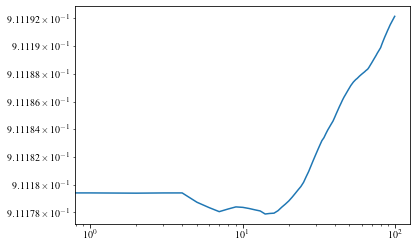

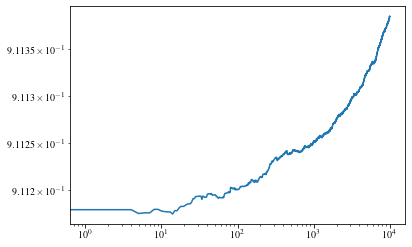

In [8]:
fig, ax = plt.subplots()
for i in range(len(gammas)):
    ax.plot(full_error_w[:100, i])
ax.set_xscale('log')
ax.set_yscale('log')
fig, ax = plt.subplots()
for i in range(len(gammas)):
    ax.plot(full_error_f[:, i])
ax.set_xscale('log')
ax.set_yscale('log')

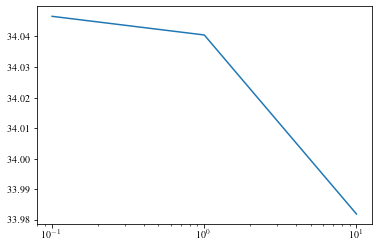

In [14]:
plt.plot(gammas, full_error_w[n_small_train - 1])
# plt.plot(gammas, full_error_f[n_small_train - 1])
plt.xscale('log')

In [11]:
ind_w = error_w.mean(axis=0).argmin(axis=1)
ind_f = error_f.mean(axis=0).argmin(axis=1)
be_w = error_w[:, np.arange(14), ind_w]
be_f = error_f[:, np.arange(14), ind_f]
ave_w = be_w.mean(axis=0)
std_w = be_w.std(axis=0)
ave_f = be_f.mean(axis=0)
std_f = be_f.std(axis=0)

fig, ax = plt.subplots(figsize=(2.5, 1.75))
a, = ax.plot(ms, ave_w, c='C0')
ax.fill_between(ms, ave_w + std_w, ave_w - std_w, color='C0', alpha=.2)
b, = ax.plot(ms, ave_f, c='C1')
ax.fill_between(ms, ave_f + std_f, ave_f - std_f, color='C1', alpha=.2)

# ax.set_xscale('log')
# ax.set_yscale('log')
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
ax.legend([a, b], ['Algo 1', 'plain SGD'], prop={'size': 6})
ax.set_title(r"Risk as a function of $m$", size=10)
ax.set_xlabel(r"Output space dimension $m$", size=8)
ax.set_ylabel(r"Risk of $\bar\theta_{10,000}$", size=8)
fig.tight_layout()
# fig.savefig("plain_m.pdf")

NameError: name 'error_w' is not defined

In [ ]:
# for i in range(len(ms)):
#     fig, ax = plt.subplots(figsize=(10, 7))
#     ax.plot(gammas, error_w.mean(axis=0)[i], c='C0')
#     ax.plot(gammas, error_f.mean(axis=0)[i], c='C1')
#     ax.set_title(f'm={ms[i]}')
#     ax.set_xscale('log')
#     ax.set_yscale('log')

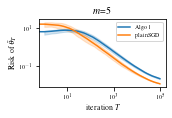

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 1.75))
fe_w = full_error_w.mean(axis=1)[:, 0, 0]
std_w = full_error_w.std(axis=1)[:, 0, 0]
fe_f = full_error_f.mean(axis=1)[:, 0, 0]
std_f = full_error_f.std(axis=1)[:, 0, 0]
a, = ax.plot(fe_w, c='C0')
ax.fill_between(np.arange(n_train) + 1, fe_w + std_w, fe_w - std_w, color='C0', alpha=.2)
b, = ax.plot(fe_f, c='C1')
ax.fill_between(np.arange(n_train) + 1, fe_f + std_f, fe_f - std_f, color='C1', alpha=.2)

ax.set_xscale('log')
ax.set_yscale('log')
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
ax.legend([a, b], ['Algo 1', 'plain SGD'], prop={'size': 6})
ax.set_title(r"$m$=5", size=10)
ax.set_xlabel(r"iteration $T$", size=8)
ax.set_ylabel(r"Risk of $\bar\theta_T$", size=8)
fig.tight_layout()
fig.savefig("plain_sgd.pdf")

(-2.0, 2.0)

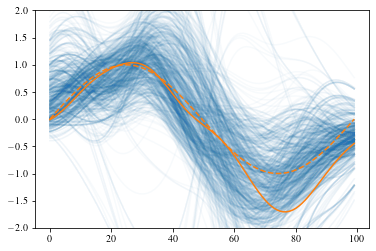

In [40]:
theta = .3 * np.random.randn(n_repr, 2)
noise = 1
y_train = target_func(x_train, phases=np.array([0, 1/4]))
y_train += noise * np.random.randn(*y_train.shape)
u = generate_random_sphere(*y_train.shape)

grad = np.empty(theta.shape)
gamma = get_stepsize(n_train, 1)
for i in range(n_train // 10):
    K_train[:] = kernel(x_train[i:i+1]).T
    epsilon = np.sign((K_train @ theta - y_train[i]) @ u[i])
    grad[:] = 1
    grad *= u[i]
    grad *= K_train.T
    grad *= epsilon * gamma[i]
    theta -= grad
    plt.plot(K_test @ theta[:, 0], alpha=.03, color='C0')
plt.plot(K_test @ theta[:,0], color='C1')
plt.plot(y_test[:, 0], color='C1', linestyle='--')
plt.ylim(-2, 2)